In [58]:
import json
import os
import pandas as pd
import numpy as np
import re

path_data = "../data/caselaw_data/"

main_attributes = json.load(open(path_data + "2301.json", "rb"))
os.mkdir("../data/caselaw_emb/") if "caselaw_emb" not in os.listdir("../data/") else 1

data = {key: [] for key in main_attributes}

for case in os.listdir(path_data):
    file = json.load(open(path_data + case, "rb"))
    for attribute in data.keys():
        data[attribute].append(file[attribute])
    
df = pd.DataFrame(data)
df["jurisdiction"] = df["jurisdiction"].apply(lambda x: x["label"])
relevant_cols = ["title", "summaryEn", "euCaselaw", "euProvisions", "jurisdiction"]
df = df[relevant_cols]
df = df[(df["euProvisions"].str.len() > 0)]
df = df.reset_index(drop = True)
df["summaryEn"] = df["summaryEn"].apply(lambda x: re.sub(r"<.*?>", "", x)) # remove html elements
df.head()

,title,summaryEn,euCaselaw,euProvisions,jurisdiction
0,"VSRH, Kž eun 27/2017-4",The case concerns the crime of fraud committed...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",Croatia
1,"Rechtbank Amsterdam, 11-06-2020, ECLI:NL:RBAMS...",The case concerns the crime of [assault.] prov...,"[{'celex': '62016CJ0367', 'name': 'Judgment of...","[{'celex': '32002F0584', 'name': '2002/584/JHA...",Netherlands
2,Wyrok Sądu Najwyższego z dnia 4 lipca 2013 r. ...,The application of detention on remand in the ...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",Poland
3,"Rechtbank Amsterdam, 14-09-2023, ECLI:NL:RBAMS...",The case concerns the crime of [unknown] provi...,[],"[{'celex': '32018R1805', 'name': 'Regulation (...",Netherlands
4,Juzgado Central de Instrucción núm. 4. Auto 88...,The case concerns the crimes of The case conce...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",Spain


$P=\frac{relevant\ retrieved\ docs}{total\ retrieved\ docs}$

$R=\frac{relevant\ retrieved\ docs}{total\ retrieved\ docs\ in\ dataset}$

$MRR=\frac{1}{|Q|}\sum_q^Q \frac{1}{rank_q}$ where

$MRR^*=\frac{1}{|Q|}\sum_q^Q \frac{1}{rank_q + missed}$ where

$rank_q = 0$ if there are no relevant documents in the retrieved search window\
where $missed$ is the number of relevant documents missed in the retrieved search window equal to at most the number non-relevant retrieved documents

$DCG=\sum_{i=1}^p\frac{rel_i}{log_2(i+1)}$


In [59]:
def get_citation_to_eu_instrument(item):
    return item["celex"] + "." + ".".join([mention["value"] for mention in item["itemsBase"] if mention["value"] != ""])

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

# at least one shared EU provision ==> similar
# at least one shared EuroVoc ==> similar
# eval - score each of the 5 retrieved cases for shared celex codes (only one celex now)

def cosine_search(query, search, query_type, df, top_k = 5):
    cosine_scores = cosine_similarity(query, search)
    score_doc = []

    denesting_label = ""
    if query_type == "euProvisions":
        denesting_label = "celex"
    elif query_type == "eurovoc":
        denesting_label = "label"

    running_mrr = 0
    running_mrr_normal = 0
    metrics = {}

    for i in range(cosine_scores.shape[0]):
        all_matches = np.argsort(cosine_scores[i])[::-1]
        best_matches = all_matches[1:top_k+1]
        query_celex = df.iloc[i][query_type][0][denesting_label]

        # see which top_k retrieved documents were retrieved
        score = []
        for retrieved_case in best_matches:
            retrieved_celex = [provision[denesting_label] for provision in df.iloc[retrieved_case][query_type]]
            score.append(int(query_celex in retrieved_celex))

        ### find all relevant cases that were missed
        missed_matches = []
        # for retrieved_case in all_matches[1:len(df_temp)]:
        for retrieved_case in all_matches[1:]:
            retrieved_celex = [provision[denesting_label] for provision in df.iloc[retrieved_case][query_type]]
            missed_matches.append(int(query_celex in retrieved_celex))

        score = np.asarray(score)
        no_missed_matches = np.sum(missed_matches) if np.sum(missed_matches) > 0 else 1
        score_doc.append([np.sum(score)/top_k, np.sum(score)/no_missed_matches])
        rank = np.where(score != 0)[0] # get first non-zero rank
        rank = (rank[0] + 1) if len(rank) > 0 else 0
        missed = np.min([len(np.where(score == 0)[0]), np.sum(missed_matches)])
        running_mrr += 1/(rank + missed) if rank != 0 else 0 # rank starts at 0 bcs. of this so rank + 1
        running_mrr_normal += 1/(rank) if rank != 0 else 0 # rank starts at 0 bcs. of this so rank + 1
        # print(f"Query score: {score}, rank of 1st relevant case: {rank}, mrr_w_penalty: {running_mrr:0.3f}, mrr: {running_mrr_normal:0.3f}, number of cases still missing in the query {missed}, total missed: {np.sum(missed_matches)}")
        
    # macro precision@k and recall@k
    precision, recall = np.mean(score_doc, 0)
    f1 = 2 * precision * recall / (precision + recall)

    metrics["precision"] = round(precision, 3)
    metrics["recall"] = round(recall, 3)
    metrics["f1"] = round(f1, 3)
    metrics["mrr_miss"] = round(running_mrr/cosine_scores.shape[0], 3)
    metrics["mrr"] = round(running_mrr_normal/cosine_scores.shape[0], 3)
    
    return metrics

In [61]:

models = ["multi_distiluse", "multi_mpnet", "bert_uncased", "multiqa_mpnet_dot", "mpnet", "tfidf", "fasttext_facilex", "fasttext_ccen"]
df_all = []

for jurisdiction in list(df["jurisdiction"].unique()):
    aux = pd.read_pickle(f"../data/caselaw_emb/{jurisdiction}/emb_{models[0]}.pickle")
    for model in models[:]:
        read_df = pd.read_pickle(f"../data/caselaw_emb/{jurisdiction}/emb_{model}.pickle")
        if type(read_df) == pd.DataFrame:
            aux[read_df.columns[-1]] = read_df[read_df.columns[-1]]
        else:
            aux[model] = list(read_df)

    df_all.append(aux)

df_all = pd.concat(df_all)
df_all.head()

,title,summaryEn,euCaselaw,euProvisions,jurisdiction,embedding_distiluse-base-multilingual-cased-v2,embedding_paraphrase-multilingual-mpnet-base-v2,embedding_bert-base-uncased,embedding_multi-qa-mpnet-base-dot-v1,embedding_all-mpnet-base-v2,tfidf,fasttext_facilex,fasttext_ccen
0,"VSRH, Kž eun 27/2017-4",The case concerns the crime of fraud committed...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",Croatia,"[-0.060692023, -0.0483583, 0.04069979, 0.00039...","[-0.0029417719, -0.14251252, -0.0032564392, 0....","[-0.25891528, 0.15294464, 0.12098108, -0.15108...","[0.01491436, -0.24617924, -0.06832751, 0.01925...","[0.045912884, -0.045568872, 0.035733487, 0.018...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.10672918, 0.027601399, -0.09663442, 0.10739...","[-0.017605778, -0.010654701, 0.011434711, 0.00..."
149,"VKSRH, II Kž-Us-2/2023-5","Vis6.1....Also, it is pointed out that the pos...","[{'celex': '62021CJ62019CJ0852', 'name': '', '...","[{'celex': '32014L0041', 'name': 'Directive 20...",Croatia,"[0.039006464, 0.0054137185, -0.014068413, -0.0...","[-0.05351017, -0.25347862, -0.007594817, 0.096...","[-0.41561508, 0.07421455, 0.039581493, -0.2414...","[-0.07343363, -0.48279944, -0.12867716, 0.2267...","[-0.0054759653, -0.032245096, 0.030678507, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.026453033, 0.04760425, -0.06889932, 0.08423...","[-0.0023025896, 0.014835966, 0.0067574643, 0.0..."
151,"USRH, U-III-4338/2022",The case relates to the criminal offense of il...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",Croatia,"[-0.034739505, -0.04323575, 0.027197685, -0.00...","[-0.028867247, 0.05017837, -0.0017340094, 0.05...","[-0.31757462, 0.09605091, -0.06465741, -0.3150...","[0.022821141, 0.023293452, -0.12143093, 0.0605...","[0.03201678, 0.04048704, 0.01769818, 0.0197229...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.056691386, 0.02140862, -0.09182702, 0.07820...","[-0.010943174, -0.0028306139, -0.008501048, 0...."
213,"VSRH, Kž eun 27/2017-4",The case concerns the crime of fraud committed...,[],"[{'celex': '32002F0584', 'name': '2002/584/JHA...",Croatia,"[-0.076421455, -0.0810934, 0.04389272, 0.04471...","[0.008581991, -0.15278411, -0.0035914378, 0.03...","[-0.29498184, 0.08304814, -0.09993943, -0.2243...","[0.03626685, -0.1418576, -0.05430969, -0.17254...","[0.028011413, -0.018695856, 0.032420006, 0.010...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.09318115, 0.017768206, -0.0811177, 0.058187...","[-0.0048100012, 0.00023710934, -0.00088316185,..."
1,"Rechtbank Amsterdam, 11-06-2020, ECLI:NL:RBAMS...",The case concerns the crime of [assault.] prov...,"[{'celex': '62016CJ0367', 'name': 'Judgment of...","[{'celex': '32002F0584', 'name': '2002/584/JHA...",Netherlands,"[-0.004692955, 0.019828657, 0.041598786, -0.00...","[0.06799634, -0.21104386, -0.003404806, 0.0039...","[-0.46271676, 0.061870918, 0.03336493, -0.3502...","[0.3660286, -0.1356406, -0.08999016, -0.030564...","[0.073336095, -0.05530721, 0.04686007, 0.01313...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.10258032, 0.056729686, -0.084975734, 0.0863...","[-0.0077452143, 0.022239797, 0.0035422053, 0.0..."


In [62]:
def cosine_search_output(query, search, query_type, df, top_k = 5):
    texts = open(f"output_combined.txt", "w")
    cosine_scores = cosine_similarity(query, search)
    score_doc = []
    hit_doc = []
    avg_p = []
    running_dcg = []

    denesting_label = ""
    if query_type == "euProvisions":
        denesting_label = "celex"
    elif query_type == "eurovoc":
        denesting_label = "label"

    running_mrr = 0
    running_mrr_normal = 0
    metrics = {}

    for i in range(cosine_scores.shape[0]):
        all_matches_m1 = np.argsort(cosine_scores[i])[::-1]

        best_matches_m1 = all_matches_m1[1:top_k+1]
        query_celex = df.iloc[i][query_type][0][denesting_label]

        if i < 5:
            texts.write(f"\n===================\n")
            texts.write(f"({df.iloc[i]['jurisdiction']}) ({query_celex}) ({df.iloc[i]['title']})\n")
            texts.write(df.iloc[i]["summaryEn"])
            texts.write(f"\n===================\nRetrieved cases (top {top_k})\n------------\n")

        # see which top_k retrieved documents were retrieved
        score = []
        for retrieved_case in best_matches_m1:
            retrieved_celex = [provision[denesting_label] for provision in df.iloc[retrieved_case][query_type]]
            score.append(int(query_celex in retrieved_celex))
            # if i < 5:
            #     texts.write(f"({query_celex in retrieved_celex}) ({df.iloc[retrieved_case]['jurisdiction']}) ({', '.join(retrieved_celex)}) ({df.iloc[retrieved_case]['title']})\n")
            #     texts.write(df.iloc[retrieved_case]["summaryEn"])
            #     texts.write("\n\n")
        # texts.write("\n------------\n")

        ### find all relevant cases that were missed
        missed_matches = []
        # for retrieved_case in all_matches[1:len(df_temp)]:
        for retrieved_case in all_matches_m1[1:]:
            retrieved_celex = [provision[denesting_label] for provision in df.iloc[retrieved_case][query_type]]
            missed_matches.append(int(query_celex in retrieved_celex))

        score = np.asarray(score)
        score_doc.append(np.sum(score)/top_k)
        hit_doc.append(np.any(score))
        rank = np.where(score != 0)[0] # get first non-zero rank
        rank = (rank[0] + 1) if len(rank) > 0 else 0
        missed = np.min([len(np.where(score == 0)[0]), np.sum(missed_matches)])
        running_mrr += 1/(rank + missed) if rank != 0 else 0 # rank starts at 0 bcs. of this so rank + 1
        running_mrr_normal += 1/(rank) if rank != 0 else 0 # rank starts at 0 bcs. of this so rank + 1

        avg_p.append(np.sum([(np.sum(score[:k])/k) * score[k-1] for k in range(1, top_k+1)])/top_k)
        running_dcg.append(np.sum(np.asarray(score)/np.log2(list(range(2,top_k+2))))/top_k)
        # print(f"Query score: {score}, rank of 1st relevant case: {rank}, mrr_w_penalty: {running_mrr:0.3f}, mrr: {running_mrr_normal:0.3f}, number of cases still missing in the query {missed}, total missed: {np.sum(missed_matches)}")
        
    metrics[f"precision@{top_k}"] = round(np.mean(score_doc, 0), 3)
    metrics[f"map@{top_k}"] = round(np.sum(avg_p)/cosine_scores.shape[0], 3)
    metrics[f"mrr_miss@{top_k}"] = round(running_mrr/cosine_scores.shape[0], 3)
    metrics[f"mrr@{top_k}"] = round(running_mrr_normal/cosine_scores.shape[0], 3)
    metrics[f"hitrate@{top_k}"] = round(np.sum(hit_doc)/cosine_scores.shape[0], 3)
    # metrics[f"DCG"] = round(np.mean(running_dcg), 3)

    # texts.close()
    
    return metrics

In [63]:
from collections import defaultdict
from functools import partial
from tqdm import tqdm

# search_functions = [partial(cosine_search, query_type = "citation"), partial(cosine_search, query_type = "euProvisions")]
# search_functions = [partial(cosine_search_output, query_type = "euProvisions")]
search_functions = [partial(cosine_search_output, query_type = "euProvisions")]

scores_search_function = defaultdict()

scores = {"Model": [], "Value": [], "Score": []}
for search_func in search_functions:
    aux = df_all.copy()
    # subset = aux.sample(10, random_state=42)
    subset = aux
    for model in tqdm(df_all.columns[5:]):
        embds_query = np.asarray(subset[model].tolist())
        embds_corpus = np.asarray(df_all[model].tolist())

        metrics = search_func(query = embds_query, search = embds_corpus, df = df_all, top_k = 5)
        scores["Model"] += [model.split("_")[-1]] * len(list(metrics.keys()))
        scores["Value"] += list(metrics.values())
        scores["Score"] += list(metrics.keys())

        name = ""
        if type(search_func) == partial:
            name = search_func.func.__name__ + "_" + "_".join(list(search_func.keywords.values()))
        else:
            name = search_func.__name__
        # scores_search_function[name] = scores

100%|██████████| 8/8 [00:19<00:00,  2.39s/it]


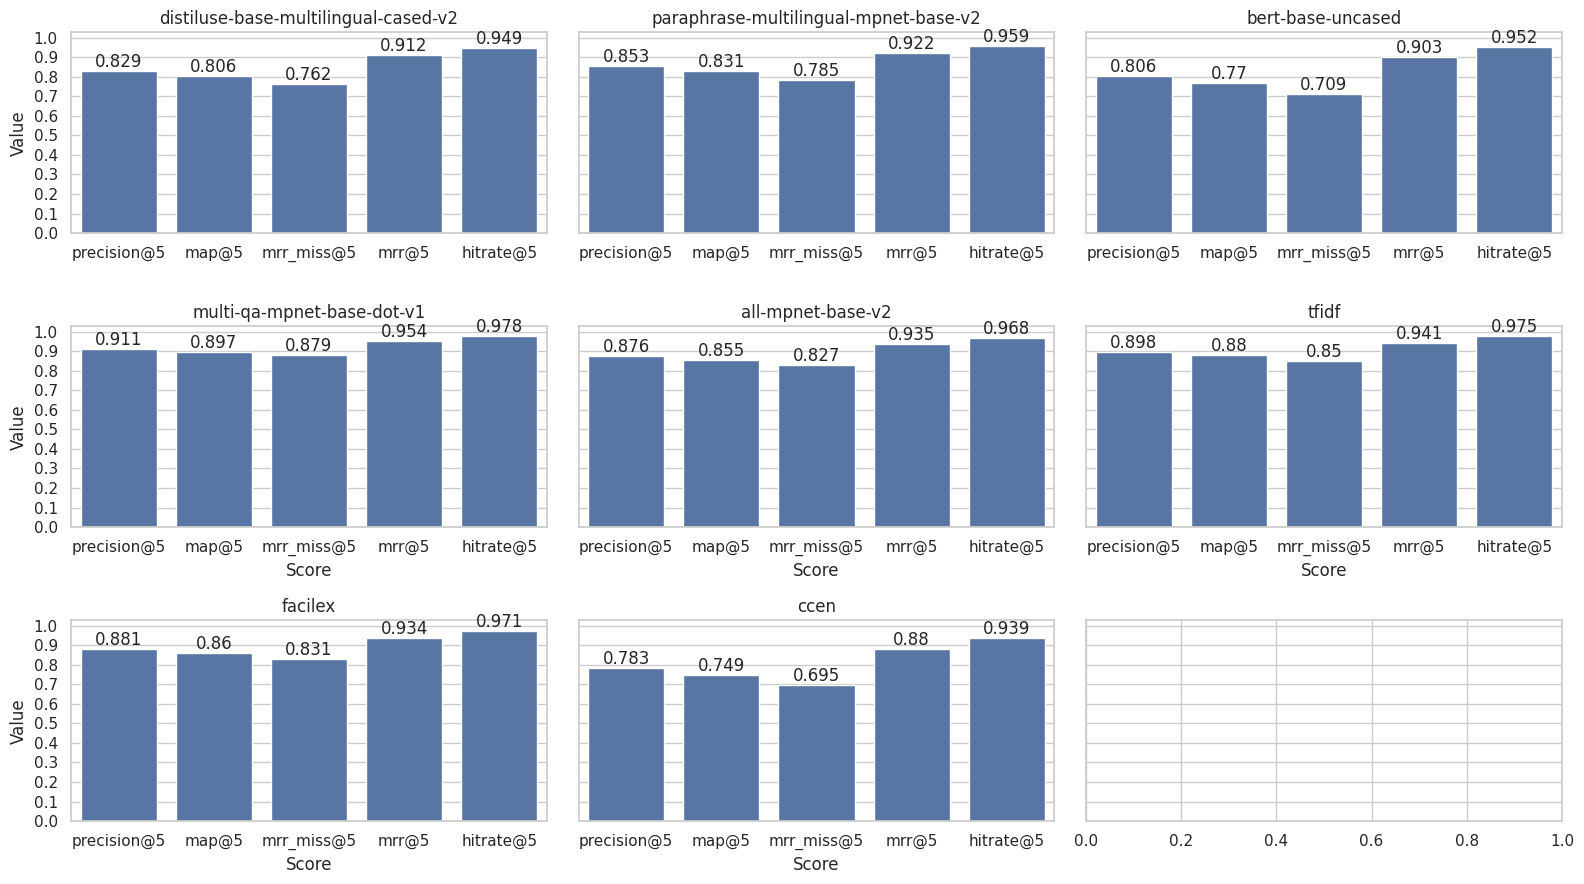

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MultipleLocator

figure_title_names = {
    "cosine_search_euProvisions": "Cosine similarity of cases using shared\nEU Legislation",
    "cosine_search_eurovoc": "Cosine similarity of cases using shared\nEuroVoc Labels",
    "cosine_search_both": "Cosine similarity of cases using both shared\nEU Legislation and EuroVoc Labels",
    "cosine_search_citation": "Cosine similarity of cases using citations of EU instruments"
}

sns.set_theme(style = "whitegrid")
_, axes = plt.subplots(len(df_all.columns[5:])//3 + 1, 3, figsize = (16,9), sharex= False, sharey=True)
axes = axes.reshape(-1,)

for idx, ax in enumerate(axes):
    if idx >= len(df_all.columns[5:]):
        continue
    scores_df = pd.DataFrame(scores).iloc[idx*5:(idx+1)*5]
    fig = sns.barplot(data = scores_df, x = "Score", y = "Value", ax = ax)
    fig.bar_label(fig.containers[0])
    fig.set_title(scores_df["Model"].iloc[0])
    fig.figure.subplots_adjust(top=0.85)

    if idx < (len(df_all.columns[5:])%3 - 1) * 3:
        fig.set_xlabel("")

    ax.yaxis.set_major_locator(MultipleLocator(0.1))

plt.tight_layout()
plt.show()